In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from lime import lime_tabular
import joblib
from tensorflow.keras.models import load_model
from preload_explainers import preload_explainers, load_background_data, PredictProbaWrapper, EnsembleProbaWrapper
from utils import load_column_mapping, preprocess_single_transaction, load_model_from_disk
import os
import pickle
import streamlit as st
from IPython.display import display, HTML

# Import custom modules
from data_loader import (
    KerasBinaryClassifier, 
    load_transaction_data, 
    preprocess_data, 
    split_data, 
    train_random_forest
)
from model_explainer import (
    explain_prediction, 
    explain_model, 
    explain_with_lime, 
    plot_lime_explanation, 
    load_models_from_cache, 
    preprocess_single_transaction
)
from utils import load_column_mapping

# -----------------------------------------------------------------------------
# Now you can load your cached explainers without that AttributeError
# -----------------------------------------------------------------------------

# Load the column mapping
column_mapping = load_column_mapping()

# Set paths for model files
models_dir    = 'models'
rf_path       = os.path.join(models_dir, 'rf_model.joblib')
nn_path       = os.path.join(models_dir, 'nn_model.h5')
ensemble_path = os.path.join(models_dir, 'ensemble_model.joblib')
explainers_path = os.path.join(models_dir, 'explainers_cache.pkl')

# Load Random Forest model
print("Loading Random Forest model...")
rf_model = joblib.load(rf_path)

# Load Neural Network model
print("Loading Neural Network model...")
keras_model = load_model(nn_path)
nn_model    = KerasBinaryClassifier(model=keras_model,
                                    n_features=rf_model.n_features_in_)

# Load Ensemble model
print("Loading Ensemble model...")
ensemble_model = joblib.load(ensemble_path)

# Load explainers from cache
print("Loading explainers from cache...")
with open(explainers_path, 'rb') as f:
    explainers = pickle.load(f)

# Create dictionary of models
models = {
    'Random Forest':    rf_model,
    'Neural Network':   nn_model,
    'Ensemble':         ensemble_model
}

print("All models and explainers loaded successfully!")

# Create and preprocess sample transaction
print("\nPreparing sample transaction...")
feature_names = ['step', 'customer', 'age', 'gender', 'zipcodeOri', 
                 'merchant', 'zipMerchant', 'category', 'amount']

sample_transaction_dict = {
    'step': 1,
    'customer': 1,
    'age': 35,
    'gender': 1,
    'zipcodeOri': 0,
    'merchant': 1,
    'zipMerchant': 0,
    'category': 1,
    'amount': 100.0
}

processed_transaction = preprocess_single_transaction(sample_transaction_dict,
                                                     column_mapping)
processed_transaction = processed_transaction.reshape(1, -1)

print("Sample transaction preprocessed successfully!")
print(f"Processed transaction shape: {processed_transaction.shape}")


Loading Random Forest model...
Loading Neural Network model...
Loading Ensemble model...
Loading explainers from cache...
All models and explainers loaded successfully!

Preparing sample transaction...
Sample transaction preprocessed successfully!
Processed transaction shape: (1, 9)


In [8]:
# Test SHAP explanations for each model
print("\nGenerating SHAP explanations...")
for model_name, model in models.items():
    print(f"\nSHAP explanation for {model_name}:")
    
    # Get model prediction
    prediction = model.predict(processed_transaction)[0]
    prediction_prob = model.predict_proba(processed_transaction)[0]
    print(f"Model prediction: {'Fraud' if prediction == 1 else 'Not Fraud'}")
    print(f"Prediction probability: Fraud: {prediction_prob[1]:.3f}, Not Fraud: {prediction_prob[0]:.3f}")
    
    # Map model name to explainer key
    model_key = model_name.lower().replace(' ', '_')
    
    # Get SHAP values
    print("Force Plot")
    force_plot = explain_prediction(model_key, processed_transaction, feature_names, explainers)
    print("type of force_plot: ", type(force_plot))
    # force_plot.matplotlib(figsize=(10, 6), show=True, text_rotation=45)
    # plt.show()
    
    # Create SHAP waterfall plot
    print("Waterfall Plot")
    waterfall_plot = explain_prediction(model_key, processed_transaction, feature_names, explainers, plot_type='waterfall')
    print("type of waterfall_plot: ", type(waterfall_plot))
    # plt.show()
    
    # Create SHAP bar plot
    print("Bar Plot")
    bar_plot = explain_prediction(model_key, processed_transaction, feature_names, explainers, plot_type='bar')
    print("type of bar_plot: ", type(bar_plot))
    # plt.show()



Generating SHAP explanations...

SHAP explanation for Random Forest:
Model prediction: Not Fraud
Prediction probability: Fraud: 0.190, Not Fraud: 0.810
Force Plot
Transaction shape: (1, 9)
Model: random_forest
SHAP values shape: (1, 9, 2)
SHAP values: [[[ 0.06542628 -0.06542628]
  [ 0.10703478 -0.10703478]
  [ 0.01985286 -0.01985286]
  [-0.00444164  0.00444164]
  [ 0.          0.        ]
  [ 0.15876186 -0.15876186]
  [ 0.          0.        ]
  [ 0.17677422 -0.17677422]
  [-0.21358258  0.21358258]]]
Single output shape: (1, 9)
Single output: [[-0.06542628 -0.10703478 -0.01985286  0.00444164  0.         -0.15876186
   0.         -0.17677422  0.21358258]]
Expected value shape: (1, 2)
Expected value: [[0.50017421 0.49982579]]
type of force_plot:  <class 'shap.plots._force.AdditiveForceVisualizer'>
Waterfall Plot
Transaction shape: (1, 9)
Model: random_forest
SHAP values shape: (1, 9, 2)
SHAP values: [[[ 0.06542628 -0.06542628]
  [ 0.10703478 -0.10703478]
  [ 0.01985286 -0.01985286]
  [-

  0%|          | 0/1 [00:00<?, ?it/s]

Model: neural_network
SHAP values shape: (1, 9, 2)
SHAP values: [[[-3.33321396e-03  3.33321396e-03]
  [ 6.66678695e-03 -6.66678695e-03]
  [-1.28765901e-07  1.28765901e-07]
  [ 3.03685665e-08 -3.03685666e-08]
  [ 0.00000000e+00  0.00000000e+00]
  [-1.30494436e-07  1.30494436e-07]
  [ 0.00000000e+00  0.00000000e+00]
  [ 1.19725863e-07 -1.19725863e-07]
  [-3.33346383e-03  3.33346383e-03]]]
Single output shape: (1, 9)
Single output: [[ 3.33321396e-03 -6.66678695e-03  1.28765901e-07 -3.03685666e-08
   0.00000000e+00  1.30494436e-07  0.00000000e+00 -1.19725863e-07
   3.33346383e-03]]
Expected value shape: (1, 2)
Expected value: [[0. 1.]]
type of force_plot:  <class 'shap.plots._force.AdditiveForceVisualizer'>
Waterfall Plot
Transaction shape: (1, 9)


  0%|          | 0/1 [00:00<?, ?it/s]

Model: neural_network
SHAP values shape: (1, 9, 2)
SHAP values: [[[-3.33321396e-03  3.33321396e-03]
  [ 6.66678695e-03 -6.66678695e-03]
  [-1.28765901e-07  1.28765901e-07]
  [ 3.03685665e-08 -3.03685666e-08]
  [ 0.00000000e+00  0.00000000e+00]
  [-1.30494436e-07  1.30494436e-07]
  [ 0.00000000e+00  0.00000000e+00]
  [ 1.19725863e-07 -1.19725863e-07]
  [-3.33346383e-03  3.33346383e-03]]]
Single output shape: (1, 9)
Single output: [[ 3.33321396e-03 -6.66678695e-03  1.28765901e-07 -3.03685666e-08
   0.00000000e+00  1.30494436e-07  0.00000000e+00 -1.19725863e-07
   3.33346383e-03]]
Expected value shape: (1, 2)
Expected value: [[0. 1.]]
type of waterfall_plot:  <class 'matplotlib.axes._axes.Axes'>
Bar Plot
Transaction shape: (1, 9)


  0%|          | 0/1 [00:00<?, ?it/s]

Model: neural_network
SHAP values shape: (1, 9, 2)
SHAP values: [[[-3.33321396e-03  3.33321396e-03]
  [ 6.66678695e-03 -6.66678695e-03]
  [-1.28765901e-07  1.28765901e-07]
  [ 3.03685665e-08 -3.03685666e-08]
  [ 0.00000000e+00  0.00000000e+00]
  [-1.30494436e-07  1.30494436e-07]
  [ 0.00000000e+00  0.00000000e+00]
  [ 1.19725863e-07 -1.19725863e-07]
  [-3.33346383e-03  3.33346383e-03]]]
Single output shape: (1, 9)
Single output: [[ 3.33321396e-03 -6.66678695e-03  1.28765901e-07 -3.03685666e-08
   0.00000000e+00  1.30494436e-07  0.00000000e+00 -1.19725863e-07
   3.33346383e-03]]
Expected value shape: (1, 2)
Expected value: [[0. 1.]]
type of bar_plot:  <class 'matplotlib.axes._axes.Axes'>

SHAP explanation for Ensemble:
collecting probas:  [array([[0., 1.]], dtype=float32), array([[0.81, 0.19]])]
collecting probas:  [array([[0., 1.]], dtype=float32), array([[0.81, 0.19]])]
Model prediction: Fraud
Prediction probability: Fraud: 0.595, Not Fraud: 0.405
Force Plot
Transaction shape: (1, 9)


  0%|          | 0/1 [00:00<?, ?it/s]

collecting probas:  [array([[0., 1.]], dtype=float32), array([[0.81, 0.19]])]
collecting probas:  [array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32), array([[0.93, 0.07],
       [0.46, 0.54],
       [0.94, 0.06],
       ...,
       [0.94, 0.06],
       [0.94, 0.06],
       [0.94, 0.06]])]
Model: ensemble
SHAP values shape: (1, 9, 2)
SHAP values: [[[-0.0015      0.0015    ]
  [-0.00991667  0.00991667]
  [-0.00025     0.00025   ]
  [-0.013225    0.013225  ]
  [ 0.          0.        ]
  [-0.02031667  0.02031667]
  [ 0.          0.        ]
  [ 0.02680833 -0.02680833]
  [-0.0015      0.0015    ]]]
Single output shape: (1, 9)
Single output: [[ 0.0015      0.00991667  0.00025     0.013225    0.          0.02031667
   0.         -0.02680833  0.0015    ]]
Expected value shape: (1, 2)
Expected value: [[0.4249 0.5751]]
type of force_plot:  <class 'shap.plots._force.AdditiveForceVisualizer'>
Waterfall Plot
Transactio

  0%|          | 0/1 [00:00<?, ?it/s]

collecting probas:  [array([[0., 1.]], dtype=float32), array([[0.81, 0.19]])]
collecting probas:  [array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32), array([[0.93, 0.07],
       [0.46, 0.54],
       [0.94, 0.06],
       ...,
       [0.94, 0.06],
       [0.94, 0.06],
       [0.94, 0.06]])]
Model: ensemble
SHAP values shape: (1, 9, 2)
SHAP values: [[[-0.0015      0.0015    ]
  [-0.00991667  0.00991667]
  [-0.00025     0.00025   ]
  [-0.013225    0.013225  ]
  [ 0.          0.        ]
  [-0.02031667  0.02031667]
  [ 0.          0.        ]
  [ 0.02680833 -0.02680833]
  [-0.0015      0.0015    ]]]
Single output shape: (1, 9)
Single output: [[ 0.0015      0.00991667  0.00025     0.013225    0.          0.02031667
   0.         -0.02680833  0.0015    ]]
Expected value shape: (1, 2)
Expected value: [[0.4249 0.5751]]
type of waterfall_plot:  <class 'matplotlib.axes._axes.Axes'>
Bar Plot
Transaction shape: (1, 9)


  0%|          | 0/1 [00:00<?, ?it/s]

collecting probas:  [array([[0., 1.]], dtype=float32), array([[0.81, 0.19]])]
collecting probas:  [array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32), array([[0.93, 0.07],
       [0.46, 0.54],
       [0.94, 0.06],
       ...,
       [0.94, 0.06],
       [0.94, 0.06],
       [0.94, 0.06]])]
Model: ensemble
SHAP values shape: (1, 9, 2)
SHAP values: [[[-0.0015      0.0015    ]
  [-0.00991667  0.00991667]
  [-0.00025     0.00025   ]
  [-0.013225    0.013225  ]
  [ 0.          0.        ]
  [-0.02031667  0.02031667]
  [ 0.          0.        ]
  [ 0.02680833 -0.02680833]
  [-0.0015      0.0015    ]]]
Single output shape: (1, 9)
Single output: [[ 0.0015      0.00991667  0.00025     0.013225    0.          0.02031667
   0.         -0.02680833  0.0015    ]]
Expected value shape: (1, 2)
Expected value: [[0.4249 0.5751]]
type of bar_plot:  <class 'matplotlib.axes._axes.Axes'>



Generating LIME explanations...

LIME explanation for Random Forest:


<Figure size 1000x600 with 0 Axes>

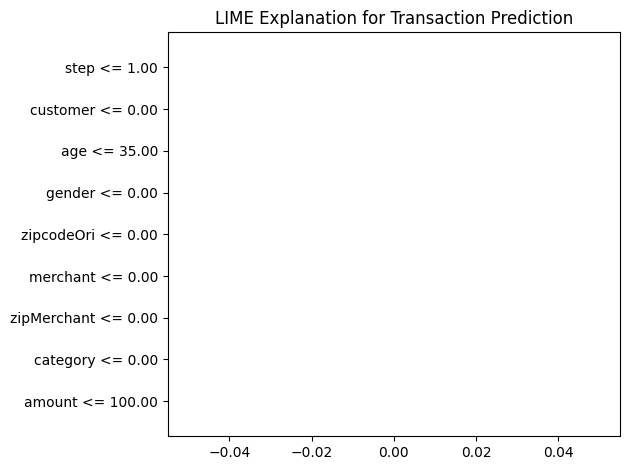

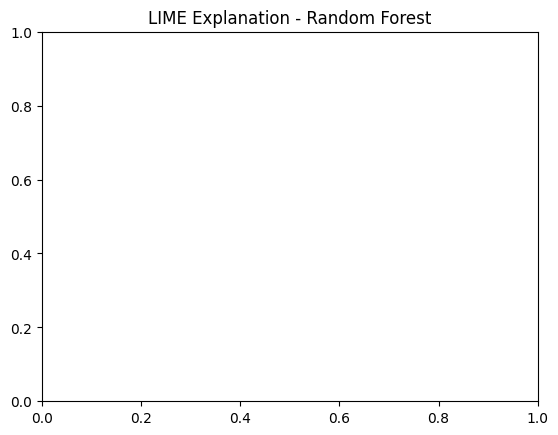


LIME explanation for Neural Network:


<Figure size 1000x600 with 0 Axes>

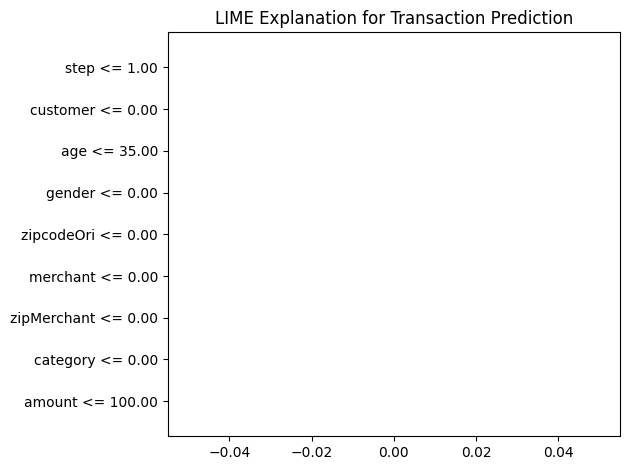

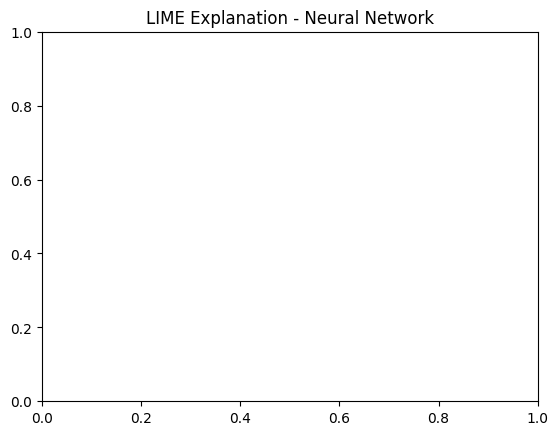


LIME explanation for Ensemble:
collecting probas:  [array([[0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 1.0466628e-11],
       [1.0000000e+00, 1.0466628e-11],
       ...,
       [1.0000000e+00, 1.0466628e-11],
       [1.0000000e+00, 1.0466628e-11],
       [1.0000000e+00, 1.0466628e-11]], dtype=float32), array([[0.81, 0.19],
       [1.  , 0.  ],
       [1.  , 0.  ],
       ...,
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ]])]


<Figure size 1000x600 with 0 Axes>

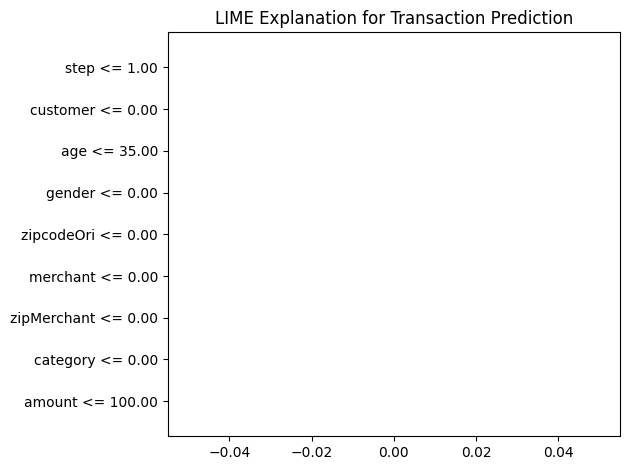

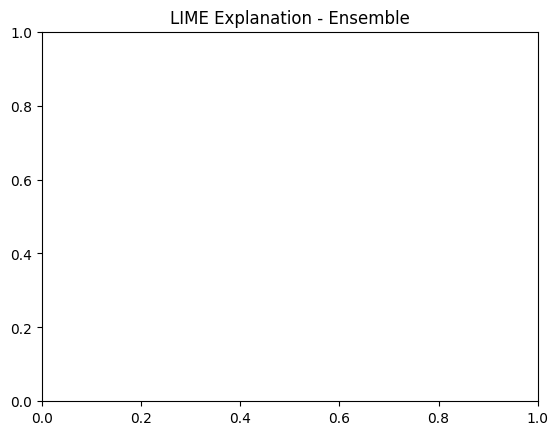

In [4]:
# Test LIME explanations for each model
print("\nGenerating LIME explanations...")
for model_name, model in models.items():
    print(f"\nLIME explanation for {model_name}:")
    try:
        # Generate LIME explanation
        lime_exp = explain_with_lime(
            model,
            processed_transaction,
            feature_names,
            ['Not Fraud', 'Fraud'],
            num_features=10,
            num_samples=5000
        )
        
        # Plot LIME explanation
        plot_lime_explanation(lime_exp)
        plt.title(f'LIME Explanation - {model_name}')
        plt.show()
        
    except Exception as e:
        print(f"Error generating LIME explanation for {model_name}: {str(e)}")





In [5]:
# Testing SHAP and LIME Explanations

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from lime import lime_tabular
import joblib
from tensorflow.keras.models import load_model
import os
from data_loader import KerasBinaryClassifier, load_transaction_data, preprocess_data, split_data, train_random_forest
from model_explainer import explain_prediction, explain_model, explain_with_lime, plot_lime_explanation, load_models_from_cache, preprocess_single_transaction
from IPython.display import HTML

# Load models
models_dir = 'models'

# Load Random Forest
rf_model = joblib.load(os.path.join(models_dir, 'rf_model.joblib'))

# Load Neural Network
keras_model = load_model(os.path.join(models_dir, 'nn_model.h5'))
nn_model = KerasBinaryClassifier(model=keras_model, n_features=rf_model.n_features_in_)

# Load Ensemble
ensemble_model = joblib.load(os.path.join(models_dir, 'ensemble_model.joblib'))

print("Models loaded successfully!")



Models loaded successfully!


In [6]:
# Create a sample transaction
feature_names = ['step', 'customer', 'age', 'gender', 'zipcodeOri', 'merchant', 'zipMerchant', 'category', 'amount']
sample_transaction = np.array([1, 1, 35, 1, 0, 1, 0, 1, 1])  # Example values

sample_transaction = preprocess_single_transaction(sample_transaction, column_mapping)

# Normalize the transaction
sample_transaction = (sample_transaction - sample_transaction.min()) / (sample_transaction.max() - sample_transaction.min())
sample_transaction = sample_transaction.reshape(1, -1)
print("sample_transaction: ", sample_transaction)

print("Sample transaction created:")
for name, value in zip(feature_names, sample_transaction[0]):
    print(f"{name}: {value:.4f}")

# Generate force plot for each model
models = {
    'Random Forest': rf_model,
    'Neural Network': nn_model,
    'Ensemble': ensemble_model
}



Exception: Error preprocessing transaction: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
# Load and preprocess data
df = load_transaction_data()
df_processed, column_mapping = preprocess_data(df)

# Split the data
X_train, X_test, y_train, y_test = split_data(df_processed)

rf_model, nn_model, ensemble_model = load_models_from_cache()

# Explain a single transaction
transaction = X_test.values[0]  # First test transaction
print("transaction: ", transaction)
print("sample_transaction: ", sample_transaction[0])
feature_names = [col for col in X_test.columns if col != 'fraud']

In [ ]:
print(f"\nGenerating force plot for {name}...")
force_plot = explain_prediction(
    rf_model,
    transaction,
    feature_names,
    plot_type='force'
)

print("force_plot: ", force_plot)

plt.show(force_plot)

force_plot.show()

# shap_html = f"<head>{shap.getjs()}</head><body style='background-color: #f0f0f0;'>{force_plot.html()}</body>"
# HTML(shap_html)


In [ ]:
print(f"\nGenerating waterfall plot for {name}...")
waterfall_plot = explain_prediction(
    rf_model,
    transaction,
    feature_names,
    plot_type='waterfall'
)

print("Waterfall: ", waterfall_plot)

plt.show(waterfall_plot)

# shap_html = f"<head>{shap.getjs()}</head><body style='background-color: #f0f0f0;'>{force_plot.html()}</body>"
# HTML(shap_html)


In [ ]:
print(f"\nGenerating bar plot for {name}...")
bar_plot = explain_prediction(
    rf_model,
    transaction,
    feature_names,
    plot_type='bar'
)
print("Bar: ", bar_plot)

plt.show(bar_plot)

In [ ]:
# Generate summary plot for each model with proper sizing
background_data = X_train.values[:100]

print("background_data.shape: ", background_data.shape)

# Set the figure size before creating the plot
plt.figure(figsize=(20, 10))  # Width, Height in inches

print(f"\nGenerating summary plot for {name}...")
summary_plot = explain_model(
    rf_model,
    background_data,
    feature_names
)

# Adjust layout and display
# plt.tight_layout()
plt.show(summary_plot)

In [ ]:


# Generate LIME explanation for each model
for name, model in models.items():
    print(f"\nGenerating LIME explanation for {name}...")
    lime_explanation = explain_with_lime(
        model,
        sample_transaction,
        feature_names,
        num_features=10,
        num_samples=5000
    )
    
    # Plot the explanation
    plot_lime_explanation(lime_explanation)
    
    # Print the explanation in text format
    print("\nLIME Explanation:")
    print(lime_explanation.as_list())
    
    # Print prediction probabilities
    print("\nPrediction Probabilities:")
    print(f"Not Fraud: {lime_explanation.predict_proba[0]:.4f}")
    print(f"Fraud: {lime_explanation.predict_proba[1]:.4f}")